In [1]:
import h5py
import numpy as np
import pandas as pd 

import fastdtw
import scipy.spatial.distance as sd

from scipy import ndimage 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from sklearn import manifold, datasets 
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt
import seaborn as sns 
plt.rcParams["figure.figsize"] = [16,9]
sns.set_style('whitegrid')

GRID_SIZE = 0.06
LOWER_LAMBDA = 6472.5
UPPER_LAMBDA = 6740
PLOT_MASK = range(1475,1550)

In [2]:
original_masked = pd.read_csv("/home/pravn/Documents/original_masked_ew_sobject_id_3.csv")

In [3]:
original_masked["sobject_id"].count()

588344

In [4]:
unproblem_ids = pd.read_csv("/home/pravn/Dropbox/unproblem_ids_buder.csv",index_col=0)

In [5]:
df_temp = pd.merge(original_masked , unproblem_ids, how='outer', indicator=True, on="sobject_id")

In [6]:
df_temp["_merge"].value_counts()

both          396338
left_only     192006
right_only        33
Name: _merge, dtype: int64

In [7]:
good_ids = df_temp.loc[df_temp["_merge"]=="both"]

Check Cotar IDs in Good IDs

In [8]:
cotar_classified = pd.read_csv("/home/pravn/Dropbox/Masters/Research Data/results.csv",index_col=0)

In [9]:
good_ids_drop = good_ids.drop(columns=["_merge"],axis=1)

In [10]:
good_ids_drop.head()

,sobject_id,1475,1476,1477,1478,1479,1480,1481,1482,1483,...,1541,1542,1543,1544,1545,1546,1547,1548,1549,EW
0,131116000501002,1.002929,1.020100,1.024491,1.022349,1.012781,0.992014,0.972579,0.980616,1.017553,...,1.000010,1.010591,0.986887,0.998070,1.034840,1.039356,1.017275,1.003299,0.992692,-0.037339
2,131116000501005,0.852568,0.855619,0.852560,0.847285,0.843284,0.833912,0.815157,0.815373,0.822885,...,0.841934,0.837705,0.847344,0.861569,0.875073,0.886794,0.884729,0.878885,0.859658,-0.094523
3,131116000501006,0.799966,0.805414,0.790533,0.784372,0.764509,0.766564,0.785371,0.782442,0.776574,...,0.834315,0.820822,0.824237,0.821758,0.825028,0.833799,0.852333,0.860145,0.859907,-0.087229
4,131116000501007,0.762165,0.753905,0.756847,0.772023,0.768651,0.756399,0.747767,0.750086,0.752324,...,0.821148,0.830479,0.826671,0.820743,0.815063,0.803316,0.793477,0.788137,0.810344,0.076844
7,131116000501012,0.820555,0.817926,0.820356,0.820411,0.803494,0.785131,0.780252,0.787406,0.796942,...,0.845522,0.834277,0.853729,0.873623,0.871357,0.868724,0.857287,0.847043,0.857832,-0.009553


In [11]:
good_ids.head()

,sobject_id,1475,1476,1477,1478,1479,1480,1481,1482,1483,...,1542,1543,1544,1545,1546,1547,1548,1549,EW,_merge
0,131116000501002,1.002929,1.020100,1.024491,1.022349,1.012781,0.992014,0.972579,0.980616,1.017553,...,1.010591,0.986887,0.998070,1.034840,1.039356,1.017275,1.003299,0.992692,-0.037339,both
2,131116000501005,0.852568,0.855619,0.852560,0.847285,0.843284,0.833912,0.815157,0.815373,0.822885,...,0.837705,0.847344,0.861569,0.875073,0.886794,0.884729,0.878885,0.859658,-0.094523,both
3,131116000501006,0.799966,0.805414,0.790533,0.784372,0.764509,0.766564,0.785371,0.782442,0.776574,...,0.820822,0.824237,0.821758,0.825028,0.833799,0.852333,0.860145,0.859907,-0.087229,both
4,131116000501007,0.762165,0.753905,0.756847,0.772023,0.768651,0.756399,0.747767,0.750086,0.752324,...,0.830479,0.826671,0.820743,0.815063,0.803316,0.793477,0.788137,0.810344,0.076844,both
7,131116000501012,0.820555,0.817926,0.820356,0.820411,0.803494,0.785131,0.780252,0.787406,0.796942,...,0.834277,0.853729,0.873623,0.871357,0.868724,0.857287,0.847043,0.857832,-0.009553,both


In [12]:
df_temp_2 = pd.merge(good_ids_drop , cotar_classified, how='outer', indicator=True, on="sobject_id")

In [13]:
df_temp_2["_merge"].value_counts()

left_only     391782
both            4556
right_only      2421
Name: _merge, dtype: int64

DTW on Halpha Cands

In [44]:
good_ids_masked = good_ids[good_ids["EW"]>0.25]

In [45]:
good_ids_masked["EW"].describe()

count    6094.000000
mean        0.591710
std         0.977460
min         0.250012
25%         0.318001
50%         0.422670
75%         0.622047
max        67.883141
Name: EW, dtype: float64

In [46]:
good_ids_masked_25_data_only = good_ids_masked.drop(columns=['EW','sobject_id','_merge'])

In [47]:
good_ids_masked_25_data_only_np = good_ids_masked_25_data_only.to_numpy()

In [18]:
def my_fastdtw(spec1, spec2):
    return fastdtw.fastdtw(spec1, spec2)[0]

In [19]:
distance_matrix = sd.pdist(good_ids_masked_25_data_only_np, my_fastdtw)

In [20]:
distance_matrix_square_form = sd.squareform(distance_matrix)

In [22]:
def distance_cost_plot(distances):
    im = plt.imshow(distances, interpolation='nearest', cmap='Blues') 
    plt.gca().invert_yaxis()
    plt.xlabel("Sample")
    plt.ylabel("Sample")
    plt.title("DTW Distance")
    plt.grid()
    plt.legend
    plt.colorbar();

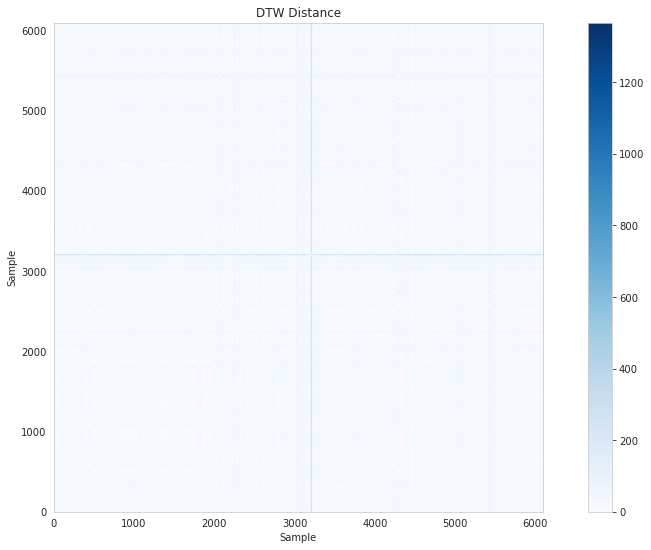

In [23]:
distance_cost_plot(distance_matrix_square_form)

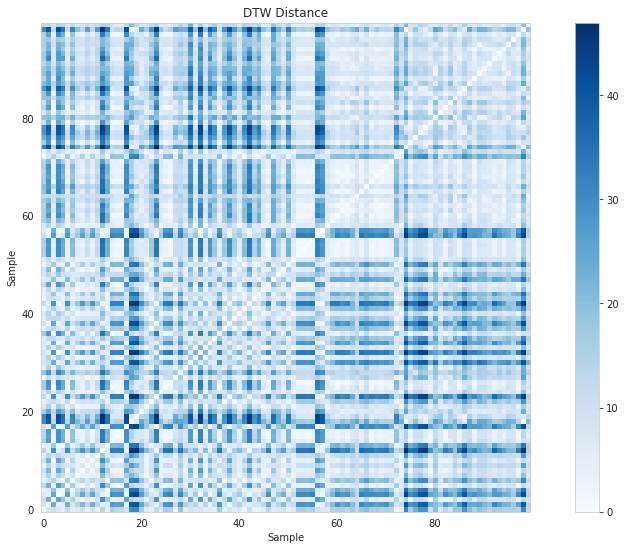

In [24]:
distance_cost_plot(distance_matrix_square_form[0:100:,0:100])

In [48]:
agglom = AgglomerativeClustering(n_clusters = 11, linkage = 'complete', affinity='precomputed')
agglom.fit(distance_matrix_square_form)
agglom.labels_

array([6, 6, 6, ..., 6, 6, 5])

In [49]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [50]:
score = silhouette_score(good_ids_masked_25_data_only_np, agglom.labels_)
print(score)

0.2811965419751366


In [51]:
old_names = good_ids_masked_25_data_only.columns.tolist()

In [52]:
hf_grid = h5py.File("/home/pravn/Dropbox/Masters/Research Data/wl_grid.h5", "r")
wl_grid = np.array(hf_grid["wl_grid"])

In [53]:
new_names = wl_grid[PLOT_MASK].tolist()

In [54]:
col_rename_dict = {i:j for i,j in zip(old_names, new_names)}

In [55]:
good_ids_masked_25_data_only.rename(columns=col_rename_dict, inplace=True)

In [56]:
good_ids_masked_25_data_only["label"] = pd.Series(agglom.labels_, index = good_ids_masked_25_data_only.index)

In [57]:
good_ids_masked_25_data_only["sobject_id"] = good_ids_masked["sobject_id"]

In [58]:
good_ids_masked_25_data_only["label"].value_counts()

6     4888
9      853
5      199
3       85
10      33
0       16
1       11
2        4
4        3
7        1
8        1
Name: label, dtype: int64

In [65]:
df_masked = good_ids_masked_25_data_only

Int64Index([  4701,   6667,  39609,  39627,  42118,  42177,  42264,  42285,
            118799, 118813, 118924, 121084, 126776, 136767, 158972, 174550,
            174563, 174621, 174658, 304090, 322014, 322254, 342241, 346407,
            348271, 354105, 532241, 532538, 542149, 547366, 562607, 564420,
            575306],
           dtype='int64')


Text(6562.78, 2.5, 'Hα')

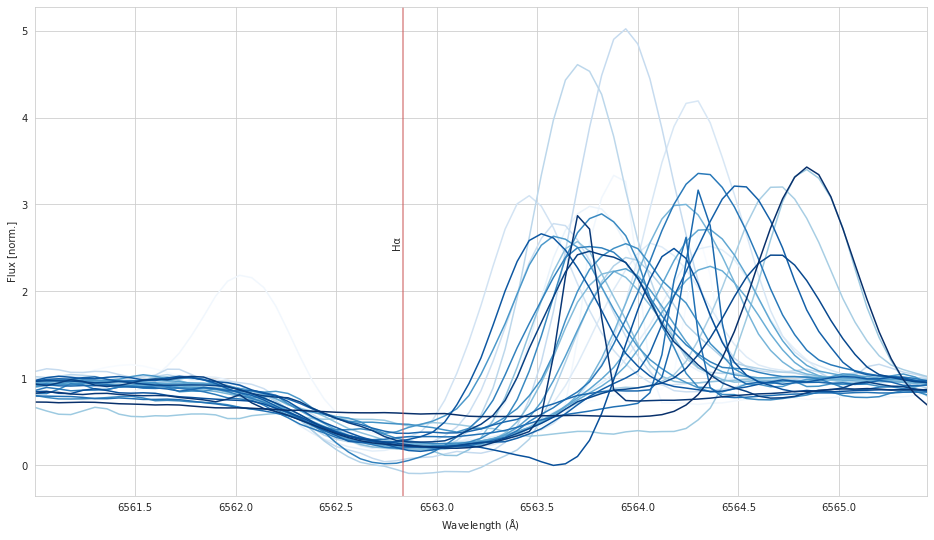

In [69]:
CLASS = 10
df_masked_label = df_masked.loc[df_masked["label"]==CLASS]
print(df_masked_label.index)
ax = (df_masked.loc[df_masked['label'] == CLASS].drop(columns=['label','sobject_id']).T).plot(
    legend=False, 
    xlabel = "Wavelength ($\mathrm{\AA}$)", 
    ylabel = "Flux [norm.]",
    #xticks = wl_grid[PLOT_MASK],
    xlim = (wl_grid[PLOT_MASK].min(),wl_grid[PLOT_MASK].max()),
    colormap = "Blues"
    )
halpha_line = ax.axvline(x=6562.83, color='indianred', label="coral", alpha=0.7)
ax.text(6562.78,2.5,"Hα", rotation=90)